In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

##### Попробуем подобрать возможную конфигурацию свёрточной сети для задачи классификации рукописных цифр
Для начала загрузим данные

In [3]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

((50000, 1, 28, 28), (50000,))


#### Посмотрим, как выглядят входные данные

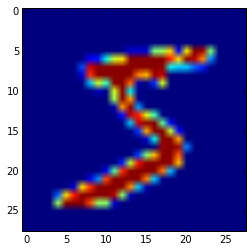

In [4]:
plt.imshow(X_train[0,0])

In [5]:
#вход у нас четырёхмерный, первый параметр задает количество примеров, второй глубину каналов, третий и четвертый - размеры входа
#у нас картинка 28 на 28
input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться"), потом идёт что-то типа глубины канала, у нас картинка чёрно-белая, поэтому
# 1, если бы была цветная, то было бы 3, как в RGB
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

#### Зададим архитектуру сети

In [15]:
# построим для начала свёрточную нейронную сеть
# архитектура нейронной сети стандартная, два свёрточных слоя, после каждого свёрточного идет пулинговый и в конце 
# полносвязный

#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

# сделаем так, чтобы у слоев не было вектора сдвигов b, потому что в нашей модели его нет
conv_1 = lasagne.layers.Conv2DLayer(input_layer, num_filters=8, filter_size=3, name='conv_1', 
                                    nonlinearity=lasagne.nonlinearities.rectify, b=None)

max_pool_1 = lasagne.layers.MaxPool2DLayer(conv_1, pool_size=(2,2), name='max_pool_1')

conv_2 = lasagne.layers.Conv2DLayer(conv_1, num_filters=8, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify, 
                                    name='conv_2', b=None)
max_pool_2 = lasagne.layers.MaxPool2DLayer(conv_2, pool_size=(2,2), name='max_pool_2')

dense_1 = lasagne.layers.DenseLayer(max_pool_2, num_units=128, b=None, name='dense_1')

#ВЫХОДНОЙ полносвязный слой, который имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1, num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output', b=None)

In [16]:
#предсказание нейронки (theano-преобразование), это результат применения softmax к выходу предпоследнего слоя
y_predicted = lasagne.layers.get_output(dense_output)

In [17]:
#все веса нейронки (shared-переменные), как раз все параметры, которые будут меняться при обучении
all_weights = lasagne.layers.get_all_params(dense_output)
print (all_weights)

[conv_1.W, conv_2.W, dense_1.W, output.W]


In [18]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
# первый параметр - что мы дифференцируем, потом по чему мы дифференцируем, ну и скорость обучения
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [19]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [20]:
from random import shuffle
import math

# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# X - тензор из картинок размером (много, 1, 28, 28), например - X_train
# y - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
#batch_size - одно число - желаемый размер группы

def iterate_minibatches(X, y, batchsize):
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield X[excerpt], y[excerpt]

#### Начинаем учить нашу сеть

In [22]:
import time
from tqdm import tqdm

num_epochs = 100 #количество проходов по данным

batch_size = 50 #размер мини-батча

train_accuracy = []
val_accuracy = []

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        
        
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    
    train_accuracy.append(train_acc / train_batches * 100)
    val_accuracy.append(val_acc / val_batches * 100)

  1%|          | 1/100 [00:49<1:21:51, 49.61s/it]

Epoch 1 of 100 took 49.614s
  training loss (in-iteration):		0.144771
  train accuracy:		95.51 %
  validation accuracy:		97.65 %
Epoch 2 of 100 took 48.041s

  2%|▏         | 2/100 [01:37<1:20:15, 49.14s/it]


  training loss (in-iteration):		0.057562
  train accuracy:		98.31 %
  validation accuracy:		98.39 %
Epoch 3 of 100 took 45.782s

  3%|▎         | 3/100 [02:23<1:17:49, 48.13s/it]


  training loss (in-iteration):		0.041095
  train accuracy:		98.77 %
  validation accuracy:		98.50 %
Epoch 4 of 100 took 47.071s

  4%|▍         | 4/100 [03:10<1:16:30, 47.82s/it]


  training loss (in-iteration):		0.033879
  train accuracy:		99.00 %
  validation accuracy:		98.35 %
Epoch 5 of 100 took 48.901s

  5%|▌         | 5/100 [03:59<1:16:13, 48.14s/it]


  training loss (in-iteration):		0.028722
  train accuracy:		99.21 %
  validation accuracy:		98.73 %
Epoch 6 of 100 took 45.272s

  6%|▌         | 6/100 [04:44<1:14:04, 47.28s/it]


  training loss (in-iteration):		0.026791
  train accuracy:		99.29 %
  validation accuracy:		98.44 %
Epoch 7 of 100 took 44.777s

  7%|▋         | 7/100 [05:29<1:12:07, 46.53s/it]


  training loss (in-iteration):		0.025644
  train accuracy:		99.33 %
  validation accuracy:		98.34 %
Epoch 8 of 100 took 45.736s

  8%|▊         | 8/100 [06:15<1:10:58, 46.29s/it]


  training loss (in-iteration):		0.021480
  train accuracy:		99.46 %
  validation accuracy:		98.67 %
Epoch 9 of 100 took 46.881s

  9%|▉         | 9/100 [07:02<1:10:28, 46.47s/it]


  training loss (in-iteration):		0.021196
  train accuracy:		99.50 %
  validation accuracy:		98.55 %
Epoch 10 of 100 took 45.619s

 10%|█         | 10/100 [07:47<1:09:19, 46.21s/it]


  training loss (in-iteration):		0.020190
  train accuracy:		99.57 %
  validation accuracy:		98.49 %
Epoch 11 of 100 took 47.251s

 11%|█         | 11/100 [08:34<1:09:00, 46.53s/it]


  training loss (in-iteration):		0.019759
  train accuracy:		99.58 %
  validation accuracy:		98.40 %
Epoch 12 of 100 took 47.706s

 12%|█▏        | 12/100 [09:22<1:08:45, 46.88s/it]


  training loss (in-iteration):		0.016248
  train accuracy:		99.69 %
  validation accuracy:		98.12 %
Epoch 13 of 100 took 48.748s

 13%|█▎        | 13/100 [10:11<1:08:47, 47.44s/it]


  training loss (in-iteration):		0.021945
  train accuracy:		99.67 %
  validation accuracy:		98.55 %
Epoch 14 of 100 took 46.502s

 14%|█▍        | 14/100 [10:57<1:07:35, 47.16s/it]


  training loss (in-iteration):		0.017799
  train accuracy:		99.67 %
  validation accuracy:		98.59 %
Epoch 15 of 100 took 48.644s

 15%|█▌        | 15/100 [11:46<1:07:26, 47.61s/it]


  training loss (in-iteration):		0.022397
  train accuracy:		99.70 %
  validation accuracy:		98.72 %
Epoch 16 of 100 took 47.707s

 16%|█▌        | 16/100 [12:34<1:06:41, 47.64s/it]


  training loss (in-iteration):		0.016584
  train accuracy:		99.77 %
  validation accuracy:		98.65 %
Epoch 17 of 100 took 45.745s

 17%|█▋        | 17/100 [13:20<1:05:06, 47.07s/it]


  training loss (in-iteration):		0.015582
  train accuracy:		99.74 %
  validation accuracy:		98.65 %
Epoch 18 of 100 took 48.114s

 18%|█▊        | 18/100 [14:08<1:04:45, 47.38s/it]


  training loss (in-iteration):		0.014081
  train accuracy:		99.80 %
  validation accuracy:		98.75 %
Epoch 19 of 100 took 47.436s

 19%|█▉        | 19/100 [14:55<1:03:59, 47.40s/it]


  training loss (in-iteration):		0.010220
  train accuracy:		99.85 %
  validation accuracy:		98.68 %
Epoch 20 of 100 took 47.124s

 20%|██        | 20/100 [15:42<1:03:05, 47.32s/it]


  training loss (in-iteration):		0.014907
  train accuracy:		99.79 %
  validation accuracy:		98.78 %
Epoch 21 of 100 took 48.536s

 21%|██        | 21/100 [16:31<1:02:47, 47.68s/it]


  training loss (in-iteration):		0.016432
  train accuracy:		99.80 %
  validation accuracy:		98.76 %
Epoch 22 of 100 took 46.995s

 22%|██▏       | 22/100 [17:18<1:01:43, 47.48s/it]


  training loss (in-iteration):		0.012628
  train accuracy:		99.82 %
  validation accuracy:		98.71 %
Epoch 23 of 100 took 49.354s

 23%|██▎       | 23/100 [18:07<1:01:39, 48.04s/it]


  training loss (in-iteration):		0.014302
  train accuracy:		99.80 %
  validation accuracy:		98.66 %
Epoch 24 of 100 took 48.257s

 24%|██▍       | 24/100 [18:55<1:00:56, 48.11s/it]


  training loss (in-iteration):		0.015645
  train accuracy:		99.79 %
  validation accuracy:		98.52 %
Epoch 25 of 100 took 47.297s

 25%|██▌       | 25/100 [19:43<59:49, 47.86s/it]  


  training loss (in-iteration):		0.018731
  train accuracy:		99.81 %
  validation accuracy:		98.66 %
Epoch 26 of 100 took 47.376s

 26%|██▌       | 26/100 [20:30<58:51, 47.72s/it]


  training loss (in-iteration):		0.017719
  train accuracy:		99.82 %
  validation accuracy:		98.63 %
Epoch 27 of 100 took 46.440s

 27%|██▋       | 27/100 [21:16<57:35, 47.33s/it]


  training loss (in-iteration):		0.015525
  train accuracy:		99.86 %
  validation accuracy:		98.55 %
Epoch 28 of 100 took 46.836s

 28%|██▊       | 28/100 [22:03<56:37, 47.19s/it]


  training loss (in-iteration):		0.014409
  train accuracy:		99.84 %
  validation accuracy:		98.74 %
Epoch 29 of 100 took 47.881s

 29%|██▉       | 29/100 [22:51<56:05, 47.39s/it]


  training loss (in-iteration):		0.018191
  train accuracy:		99.84 %
  validation accuracy:		98.74 %
Epoch 30 of 100 took 47.452s

 30%|███       | 30/100 [23:39<55:18, 47.41s/it]


  training loss (in-iteration):		0.017408
  train accuracy:		99.87 %
  validation accuracy:		98.52 %
Epoch 31 of 100 took 48.090s

 31%|███       | 31/100 [24:27<54:45, 47.62s/it]


  training loss (in-iteration):		0.015392
  train accuracy:		99.87 %
  validation accuracy:		98.61 %
Epoch 32 of 100 took 46.795s

 32%|███▏      | 32/100 [25:14<53:41, 47.37s/it]


  training loss (in-iteration):		0.016884
  train accuracy:		99.85 %
  validation accuracy:		98.74 %
Epoch 33 of 100 took 49.136s

 33%|███▎      | 33/100 [26:03<53:29, 47.90s/it]


  training loss (in-iteration):		0.018428
  train accuracy:		99.86 %
  validation accuracy:		98.76 %
Epoch 34 of 100 took 48.414s

 34%|███▍      | 34/100 [26:51<52:51, 48.05s/it]


  training loss (in-iteration):		0.010959
  train accuracy:		99.90 %
  validation accuracy:		98.76 %
Epoch 35 of 100 took 46.851s

 35%|███▌      | 35/100 [27:38<51:40, 47.69s/it]


  training loss (in-iteration):		0.011063
  train accuracy:		99.91 %
  validation accuracy:		98.76 %
Epoch 36 of 100 took 47.980s

 36%|███▌      | 36/100 [28:26<50:57, 47.78s/it]


  training loss (in-iteration):		0.010676
  train accuracy:		99.91 %
  validation accuracy:		98.90 %
Epoch 37 of 100 took 48.027s

 37%|███▋      | 37/100 [29:14<50:14, 47.85s/it]


  training loss (in-iteration):		0.010923
  train accuracy:		99.92 %
  validation accuracy:		98.68 %
Epoch 38 of 100 took 48.355s

 38%|███▊      | 38/100 [30:02<49:36, 48.01s/it]


  training loss (in-iteration):		0.017153
  train accuracy:		99.88 %
  validation accuracy:		98.68 %
Epoch 39 of 100 took 47.991s

 39%|███▉      | 39/100 [30:50<48:48, 48.00s/it]


  training loss (in-iteration):		0.011318
  train accuracy:		99.91 %
  validation accuracy:		98.77 %
Epoch 40 of 100 took 48.416s

 40%|████      | 40/100 [31:39<48:07, 48.13s/it]


  training loss (in-iteration):		0.015866
  train accuracy:		99.88 %
  validation accuracy:		98.65 %
Epoch 41 of 100 took 47.013s

 41%|████      | 41/100 [32:26<46:59, 47.79s/it]


  training loss (in-iteration):		0.009290
  train accuracy:		99.93 %
  validation accuracy:		98.65 %
Epoch 42 of 100 took 47.870s

 42%|████▏     | 42/100 [33:14<46:13, 47.82s/it]


  training loss (in-iteration):		0.015338
  train accuracy:		99.90 %
  validation accuracy:		98.57 %
Epoch 43 of 100 took 48.016s

 43%|████▎     | 43/100 [34:02<45:28, 47.88s/it]


  training loss (in-iteration):		0.015338
  train accuracy:		99.88 %
  validation accuracy:		98.83 %
Epoch 44 of 100 took 48.872s

 44%|████▍     | 44/100 [34:50<44:57, 48.18s/it]


  training loss (in-iteration):		0.014661
  train accuracy:		99.89 %
  validation accuracy:		98.72 %
Epoch 45 of 100 took 45.263s

 45%|████▌     | 45/100 [35:36<43:21, 47.30s/it]


  training loss (in-iteration):		0.009023
  train accuracy:		99.92 %
  validation accuracy:		98.72 %
Epoch 46 of 100 took 46.640s

 46%|████▌     | 46/100 [36:22<42:23, 47.10s/it]


  training loss (in-iteration):		0.014120
  train accuracy:		99.90 %
  validation accuracy:		98.75 %
Epoch 47 of 100 took 48.304s

 47%|████▋     | 47/100 [37:11<41:55, 47.47s/it]


  training loss (in-iteration):		0.008324
  train accuracy:		99.96 %
  validation accuracy:		98.79 %
Epoch 48 of 100 took 48.113s

 48%|████▊     | 48/100 [37:59<41:18, 47.66s/it]


  training loss (in-iteration):		0.008441
  train accuracy:		99.94 %
  validation accuracy:		98.82 %
Epoch 49 of 100 took 48.752s

 49%|████▉     | 49/100 [38:48<40:47, 47.99s/it]


  training loss (in-iteration):		0.013645
  train accuracy:		99.92 %
  validation accuracy:		98.68 %
Epoch 50 of 100 took 47.686s

 50%|█████     | 50/100 [39:35<39:54, 47.90s/it]


  training loss (in-iteration):		0.018874
  train accuracy:		99.89 %
  validation accuracy:		98.80 %
Epoch 51 of 100 took 47.618s

 51%|█████     | 51/100 [40:23<39:02, 47.81s/it]


  training loss (in-iteration):		0.009675
  train accuracy:		99.93 %
  validation accuracy:		98.87 %
Epoch 52 of 100 took 47.836s

 52%|█████▏    | 52/100 [41:11<38:15, 47.82s/it]


  training loss (in-iteration):		0.014544
  train accuracy:		99.94 %
  validation accuracy:		98.73 %
Epoch 53 of 100 took 48.223s

 53%|█████▎    | 53/100 [41:59<37:33, 47.94s/it]


  training loss (in-iteration):		0.016710
  train accuracy:		99.91 %
  validation accuracy:		98.88 %
Epoch 54 of 100 took 47.495s

 54%|█████▍    | 54/100 [42:46<36:39, 47.81s/it]


  training loss (in-iteration):		0.008804
  train accuracy:		99.95 %
  validation accuracy:		98.94 %
Epoch 55 of 100 took 48.767s

 55%|█████▌    | 55/100 [43:35<36:04, 48.10s/it]


  training loss (in-iteration):		0.012508
  train accuracy:		99.90 %
  validation accuracy:		98.54 %
Epoch 56 of 100 took 48.951s

 56%|█████▌    | 56/100 [44:24<35:27, 48.35s/it]


  training loss (in-iteration):		0.009415
  train accuracy:		99.95 %
  validation accuracy:		98.78 %
Epoch 57 of 100 took 48.985s

 57%|█████▋    | 57/100 [45:13<34:47, 48.54s/it]


  training loss (in-iteration):		0.008340
  train accuracy:		99.95 %
  validation accuracy:		98.56 %
Epoch 58 of 100 took 51.969s

 58%|█████▊    | 58/100 [46:05<34:41, 49.57s/it]


  training loss (in-iteration):		0.013650
  train accuracy:		99.93 %
  validation accuracy:		98.86 %
Epoch 59 of 100 took 50.212s

 59%|█████▉    | 59/100 [46:55<34:00, 49.76s/it]


  training loss (in-iteration):		0.016835
  train accuracy:		99.91 %
  validation accuracy:		98.90 %
Epoch 60 of 100 took 50.274s

 60%|██████    | 60/100 [47:46<33:16, 49.92s/it]


  training loss (in-iteration):		0.015731
  train accuracy:		99.93 %
  validation accuracy:		98.84 %
Epoch 61 of 100 took 50.164s

 61%|██████    | 61/100 [48:36<32:29, 49.99s/it]


  training loss (in-iteration):		0.010064
  train accuracy:		99.95 %
  validation accuracy:		98.91 %
Epoch 62 of 100 took 52.199s

 62%|██████▏   | 62/100 [49:28<32:04, 50.65s/it]


  training loss (in-iteration):		0.006877
  train accuracy:		99.97 %
  validation accuracy:		98.99 %
Epoch 63 of 100 took 52.984s

 63%|██████▎   | 63/100 [50:21<31:40, 51.35s/it]


  training loss (in-iteration):		0.010740
  train accuracy:		99.95 %
  validation accuracy:		98.87 %
Epoch 64 of 100 took 51.580s

 64%|██████▍   | 64/100 [51:13<30:51, 51.42s/it]


  training loss (in-iteration):		0.006837
  train accuracy:		99.97 %
  validation accuracy:		98.85 %
Epoch 65 of 100 took 50.409s

 65%|██████▌   | 65/100 [52:03<29:49, 51.12s/it]


  training loss (in-iteration):		0.006556
  train accuracy:		99.96 %
  validation accuracy:		98.84 %
Epoch 66 of 100 took 50.925s

 66%|██████▌   | 66/100 [52:54<28:56, 51.06s/it]


  training loss (in-iteration):		0.005020
  train accuracy:		99.97 %
  validation accuracy:		98.84 %
Epoch 67 of 100 took 51.983s

 67%|██████▋   | 67/100 [53:46<28:14, 51.34s/it]


  training loss (in-iteration):		0.006241
  train accuracy:		99.97 %
  validation accuracy:		98.84 %
Epoch 68 of 100 took 52.161s

 68%|██████▊   | 68/100 [54:38<27:30, 51.59s/it]


  training loss (in-iteration):		0.003036
  train accuracy:		99.98 %
  validation accuracy:		98.81 %
Epoch 69 of 100 took 51.992s

 69%|██████▉   | 69/100 [55:30<26:42, 51.71s/it]


  training loss (in-iteration):		0.002596
  train accuracy:		99.98 %
  validation accuracy:		98.77 %
Epoch 70 of 100 took 50.083s

 70%|███████   | 70/100 [56:20<25:36, 51.22s/it]


  training loss (in-iteration):		0.003641
  train accuracy:		99.98 %
  validation accuracy:		98.82 %
Epoch 71 of 100 took 51.787s

 71%|███████   | 71/100 [57:12<24:50, 51.39s/it]


  training loss (in-iteration):		0.009980
  train accuracy:		99.95 %
  validation accuracy:		98.91 %
Epoch 72 of 100 took 51.916s

 72%|███████▏  | 72/100 [58:04<24:03, 51.55s/it]


  training loss (in-iteration):		0.001851
  train accuracy:		99.99 %
  validation accuracy:		98.83 %
Epoch 73 of 100 took 54.421s

 73%|███████▎  | 73/100 [58:58<23:35, 52.41s/it]


  training loss (in-iteration):		0.006643
  train accuracy:		99.98 %
  validation accuracy:		98.87 %
Epoch 74 of 100 took 55.389s

 74%|███████▍  | 74/100 [59:54<23:05, 53.30s/it]


  training loss (in-iteration):		0.007174
  train accuracy:		99.99 %
  validation accuracy:		98.72 %
Epoch 75 of 100 took 51.473s

 75%|███████▌  | 75/100 [1:00:45<21:58, 52.76s/it]


  training loss (in-iteration):		0.006350
  train accuracy:		99.97 %
  validation accuracy:		98.78 %
Epoch 76 of 100 took 51.465s

 76%|███████▌  | 76/100 [1:01:37<20:56, 52.37s/it]


  training loss (in-iteration):		0.003347
  train accuracy:		99.99 %
  validation accuracy:		98.89 %
Epoch 77 of 100 took 52.771s

 77%|███████▋  | 77/100 [1:02:29<20:07, 52.49s/it]


  training loss (in-iteration):		0.003244
  train accuracy:		99.98 %
  validation accuracy:		99.06 %
Epoch 78 of 100 took 55.475s

 78%|███████▊  | 78/100 [1:03:25<19:34, 53.39s/it]


  training loss (in-iteration):		0.001811
  train accuracy:		99.99 %
  validation accuracy:		98.86 %
Epoch 79 of 100 took 53.080s

 79%|███████▉  | 79/100 [1:04:18<18:39, 53.29s/it]


  training loss (in-iteration):		0.001839
  train accuracy:		99.99 %
  validation accuracy:		98.94 %
Epoch 80 of 100 took 51.839s

 80%|████████  | 80/100 [1:05:10<17:37, 52.86s/it]


  training loss (in-iteration):		0.008085
  train accuracy:		99.97 %
  validation accuracy:		98.92 %
Epoch 81 of 100 took 51.466s

 81%|████████  | 81/100 [1:06:01<16:36, 52.44s/it]


  training loss (in-iteration):		0.011902
  train accuracy:		99.96 %
  validation accuracy:		98.86 %
Epoch 82 of 100 took 52.803s

 82%|████████▏ | 82/100 [1:06:54<15:45, 52.55s/it]


  training loss (in-iteration):		0.016189
  train accuracy:		99.95 %
  validation accuracy:		98.70 %
Epoch 83 of 100 took 53.159s

 83%|████████▎ | 83/100 [1:07:47<14:56, 52.73s/it]


  training loss (in-iteration):		0.014023
  train accuracy:		99.95 %
  validation accuracy:		98.91 %
Epoch 84 of 100 took 51.101s

 84%|████████▍ | 84/100 [1:08:38<13:55, 52.24s/it]


  training loss (in-iteration):		0.011743
  train accuracy:		99.95 %
  validation accuracy:		98.86 %
Epoch 85 of 100 took 53.461s

 85%|████████▌ | 85/100 [1:09:32<13:09, 52.61s/it]


  training loss (in-iteration):		0.005608
  train accuracy:		99.97 %
  validation accuracy:		98.85 %
Epoch 86 of 100 took 55.395s

 86%|████████▌ | 86/100 [1:10:27<12:28, 53.45s/it]


  training loss (in-iteration):		0.010098
  train accuracy:		99.97 %
  validation accuracy:		98.79 %
Epoch 87 of 100 took 51.466s

 87%|████████▋ | 87/100 [1:11:19<11:27, 52.85s/it]


  training loss (in-iteration):		0.012637
  train accuracy:		99.95 %
  validation accuracy:		98.83 %
Epoch 88 of 100 took 53.591s

 88%|████████▊ | 88/100 [1:12:12<10:36, 53.07s/it]


  training loss (in-iteration):		0.009329
  train accuracy:		99.96 %
  validation accuracy:		98.81 %
Epoch 89 of 100 took 53.190s

 89%|████████▉ | 89/100 [1:13:05<09:44, 53.11s/it]


  training loss (in-iteration):		0.004446
  train accuracy:		99.97 %
  validation accuracy:		98.76 %
Epoch 90 of 100 took 53.395s

 90%|█████████ | 90/100 [1:13:59<08:51, 53.20s/it]


  training loss (in-iteration):		0.009426
  train accuracy:		99.97 %
  validation accuracy:		98.81 %
Epoch 91 of 100 took 54.176s

 91%|█████████ | 91/100 [1:14:53<08:01, 53.49s/it]


  training loss (in-iteration):		0.013232
  train accuracy:		99.95 %
  validation accuracy:		98.82 %
Epoch 92 of 100 took 52.051s

 92%|█████████▏| 92/100 [1:15:45<07:04, 53.06s/it]


  training loss (in-iteration):		0.012401
  train accuracy:		99.96 %
  validation accuracy:		98.85 %
Epoch 93 of 100 took 53.773s

 93%|█████████▎| 93/100 [1:16:39<06:12, 53.27s/it]


  training loss (in-iteration):		0.013682
  train accuracy:		99.97 %
  validation accuracy:		98.87 %
Epoch 94 of 100 took 54.804s

 94%|█████████▍| 94/100 [1:17:34<05:22, 53.73s/it]


  training loss (in-iteration):		0.011414
  train accuracy:		99.97 %
  validation accuracy:		98.84 %
Epoch 95 of 100 took 54.569s

 95%|█████████▌| 95/100 [1:18:28<04:29, 53.98s/it]


  training loss (in-iteration):		0.008211
  train accuracy:		99.97 %
  validation accuracy:		98.82 %
Epoch 96 of 100 took 55.545s

 96%|█████████▌| 96/100 [1:19:24<03:37, 54.45s/it]


  training loss (in-iteration):		0.007009
  train accuracy:		99.97 %
  validation accuracy:		98.87 %
Epoch 97 of 100 took 54.446s

 97%|█████████▋| 97/100 [1:20:18<02:43, 54.45s/it]


  training loss (in-iteration):		0.015158
  train accuracy:		99.94 %
  validation accuracy:		98.76 %
Epoch 98 of 100 took 54.359s

 98%|█████████▊| 98/100 [1:21:12<01:48, 54.42s/it]


  training loss (in-iteration):		0.014104
  train accuracy:		99.96 %
  validation accuracy:		98.90 %
Epoch 99 of 100 took 53.951s

 99%|█████████▉| 99/100 [1:22:06<00:54, 54.28s/it]


  training loss (in-iteration):		0.022246
  train accuracy:		99.94 %
  validation accuracy:		98.83 %
Epoch 100 of 100 took 52.951s

100%|██████████| 100/100 [1:22:59<00:00, 53.88s/it]


  training loss (in-iteration):		0.011361
  train accuracy:		99.96 %
  validation accuracy:		98.89 %


#### Смотрим на результат обучения

In [23]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: колдун 80 уровня")
else:
    print ("Нужно больше магии!")

Final results:
  test accuracy:		98.79 %
Нужно больше магии!


In [24]:
# теперь попробуем вывести все веса нашей сети
print("params: ", lasagne.layers.get_all_param_values(dense_output))

('params: ', [array([[[[-1.68489865, -1.91531564, -0.84910267],
         [-0.86631907,  0.30968072, -0.42978998],
         [ 0.10083699,  1.02227585, -0.29114434]]],


       [[[-0.10894491, -0.33483299,  0.46094245],
         [-2.99216939,  0.53515676,  0.54093119],
         [-1.43663378, -0.44250234,  0.54557594]]],


       [[[-1.07936232, -0.86287543,  1.55196222],
         [ 0.16180982, -1.90251668, -0.20478025],
         [ 1.3933854 , -0.80489269, -1.95057296]]],


       [[[ 0.98996763,  0.41892641,  0.48946103],
         [-0.04358067,  0.29792653,  0.17409494],
         [-1.53962853, -1.43648517,  0.28220699]]],


       [[[ 0.86293065, -1.82866941, -1.26071219],
         [ 0.71259454, -0.87206671, -1.1761218 ],
         [ 0.30295663, -0.75318072, -1.62765372]]],


       [[[-0.83331957, -1.0286658 , -0.55144678],
         [ 0.36121003, -0.15657695,  0.31857342],
         [ 0.91051192,  0.4108886 ,  0.13267836]]],


       [[[ 1.61798607, -1.94838594, -2.32245458],
         [-1

In [25]:
#сохраняем всё в файлик
np.savez('cnn_weights.npz', *lasagne.layers.get_all_param_values(dense_output))

In [30]:
#так можно установить веса
with np.load('cnn_weights.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(dense_output, param_values)